#### Imports

In [92]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as ps

#### Preparing dataset for ML model

In [93]:
linkedin = pd.read_csv('../data/linkedin_standarized.csv')
linkedin.sample(5)

,job_id,job_title,company_name,company_state,salary_range,remote_ratio,employment_type,experience_level,company_size,image_link,employees,salary,original_title
221,3759308653,Data Engineer,eSense Incorporated,MA,150.000 $/año - 200.000 $/año,Híbrido,Jornada completa,Intermedio,M,https://media.licdn.com/dms/image/C4E0BAQECWke...,De 51 a 200 empleados,175000.0,Data Engineer
768,3777403893,Machine Learning Engineer,Rockwell Automation,OH,139.700 $/año - 247.300 $/año,En remoto,Jornada completa,Intermedio,L,https://media.licdn.com/dms/image/C560BAQFRXUK...,Más de 10.001 empleados,193500.0,Machine Learning Engineer
523,3771454543,Machine Learning Engineer,Tiposi,CA,65.000 $/año - 72.000 $/año,Presencial,Jornada completa,Sin experiencia,M,https://media.licdn.com/dms/image/C560BAQGafuS...,De 11 a 50 empleados,68500.0,MWI AI/ML Engineer
776,3777470353,AI Engineer,Lasso,CA,120.000 $/año - 160.000 $/año,Presencial,Jornada completa,Sin experiencia,S,https://media.licdn.com/dms/image/D560BAQEtaSz...,Entre 1 y 10 empleados,140000.0,AI Engineer
716,3776708388,Machine Learning Engineer,Leastsquare,NY,144.000 $/año - 270.250 $/año,En remoto,Jornada completa,Intermedio,S,https://media.licdn.com/dms/image/D4E0BAQEA1Mu...,Entre 1 y 10 empleados,207125.0,Founding Engineer (Machine Learning)


In [94]:
linkedin.shape
linkedin['company_size'].value_counts()

company_size
L    536
M    220
S     31
Name: count, dtype: int64

First we need to see which columns have null values.

In [95]:
linkedin.isna().sum()

job_id               0
job_title            0
company_name         0
company_state        0
salary_range        65
remote_ratio         0
employment_type      0
experience_level     0
company_size         0
image_link           0
employees            0
salary              69
original_title       0
dtype: int64

The ones with salary range in null value, are going to be the predicted ones.

In [96]:
to_predict = linkedin[linkedin['salary'].isnull()]
to_predict.shape

(69, 13)

In [97]:
linkedin = linkedin[~linkedin['salary'].isnull()]
linkedin.shape

(718, 13)

In [98]:
linkedin['employment_type'].value_counts()

employment_type
Jornada completa     570
Contrato por obra    120
Prácticas             28
Name: count, dtype: int64

Let's save this dataframe for sql queries.

In [99]:
linkedin.to_csv('../data/linkedin_salaries_sql.csv', index=False)

Let's check again null values in order to delete those rows.

In [100]:
linkedin.isna().sum()

job_id              0
job_title           0
company_name        0
company_state       0
salary_range        0
remote_ratio        0
employment_type     0
experience_level    0
company_size        0
image_link          0
employees           0
salary              0
original_title      0
dtype: int64

In [101]:
linkedin = linkedin.dropna()

In [102]:
linkedin.shape

(718, 13)

##### Function to clean both datasets

In [103]:
prepared_to_predict = to_predict[~to_predict.drop(['salary', 'salary_range'], axis=1).isna().all(axis=1)]
prepared_to_predict.shape

(69, 13)

In [104]:
prepared_to_predict.isna().sum()

job_id               0
job_title            0
company_name         0
company_state        0
salary_range        65
remote_ratio         0
employment_type      0
experience_level     0
company_size         0
image_link           0
employees            0
salary              69
original_title       0
dtype: int64

In [105]:
prepared_to_predict.shape

(69, 13)

    Column 'job_title'

Classificating the job_title category with numbers.

In [106]:
linkedin.groupby('job_title')['salary'].mean().reset_index().sort_values(by='salary', ascending=False)

,job_title,salary
7,Deep Learning Engineer,173151.066667
8,Machine Learning Engineer,160196.896341
9,Research Engineer,149496.500000
6,Data Scientist,143585.000000
5,Data Engineer,133813.465116
1,BI Analyst,123222.750000
0,AI Engineer,117393.076923
4,Data Analyst,115355.708333
2,BI Engineer,84333.333333
3,Business Analyst,71470.000000


    Column 'remote_ratio'

In [107]:
linkedin['remote_ratio'].value_counts()

remote_ratio
En remoto     280
Híbrido       238
Presencial    200
Name: count, dtype: int64

    Column 'employment_type'

In [108]:
linkedin['employment_type'].value_counts()

employment_type
Jornada completa     570
Contrato por obra    120
Prácticas             28
Name: count, dtype: int64

    Column 'experience_level'

In [109]:
linkedin['experience_level'].value_counts()

experience_level
Intermedio                 348
Sin experiencia            248
Algo de responsabilidad     54
Prácticas                   51
Director                    15
Ejecutivo                    2
Name: count, dtype: int64

    Column 'company_size'

In [110]:
linkedin['company_size'].value_counts()

company_size
L    488
M    202
S     28
Name: count, dtype: int64

    Column 'company_state'

In [111]:
linkedin['company_state'].value_counts()

company_state
CA     128
USA     88
NY      61
TX      61
WA      50
VA      33
IL      31
OH      31
FL      29
MA      21
NJ      19
MD      16
PA      14
MI      10
OR      10
AZ      10
NC      10
MN       9
MO       9
CO       7
KY       6
IN       6
UT       6
CT       6
AR       5
GA       5
WI       4
OK       4
IA       4
TN       4
KS       3
NE       3
HI       2
RI       2
NH       2
LA       1
NV       1
SC       1
SD       1
VT       1
ID       1
AL       1
DE       1
NM       1
Name: count, dtype: int64

#### Cleaning function

In [112]:
def categorizing_dataset(dframe):
    # ------ Cleaning: group
    df = dframe.copy()

    # 1. job_title
    job_categories = {
        'Deep Learning Engineer': 10,
        'Machine Learning Engineer': 9,
        'Research Engineer': 8,
        'BI Analyst': 7,
        'Data Scientist': 6,
        'Data Engineer': 5,
        'Data Analyst': 4,
        'Business Analyst': 3,
        'AI Engineer': 2,
        'BI Engineer': 1
    }
    df["job_title"] = df.job_title.replace(job_categories)

    # 2. remote_ratio
    remote_categories = {
        'En remoto': 100,
        'Híbrido': 50,
        'Presencial': 0
    }
    df["remote_ratio"] = df.remote_ratio.replace(remote_categories)

    # 3. employment_type
    employment_type = {
        'Jornada completa': 4,
        'Media jornada': 3,
        'Contrato por obra': 2,
        'Prácticas': 1,
        'Temporal': 0
    }
    df['employment_type'] = df.employment_type.replace(employment_type)

    # 4. experience_level
    experience_categories = {
        'Director': 6,
        'Ejecutivo': 5,
        'Algo de responsabilidad': 4,
        'Intermedio': 3,
        'Sin experiencia': 2,
        'Temporal': 1,
        'Prácticas': 0
    }
    df["experience_level"] = df.experience_level.replace(experience_categories)

    # 5. company_size
    oneonehotencoder = ps.OneHotEncoder()
    df[['L', 'M', 'S']] = oneonehotencoder.fit_transform(df["company_size"].values.reshape(-1, 1)).toarray()

    # 6. company_state
    # PENDING

    return df

In [113]:
linkedin['company_size'].unique()

array(['M', 'L', 'S'], dtype=object)

In [114]:
prepared_linkedin = categorizing_dataset(linkedin)
prepared_linkedin.sample(5)

,job_id,job_title,company_name,company_state,salary_range,remote_ratio,employment_type,experience_level,company_size,image_link,employees,salary,original_title,L,M,S
269,3761818335,4,Sedgwick,UT,140.000 $/año - 170.000 $/año,50,4,3,L,https://media.licdn.com/dms/image/D560BAQGtkHl...,Más de 10.001 empleados,155000.0,Data Analyst,1.0,0.0,0.0
401,3767595033,4,SynergisticIT,IL,45 $/h - 55 $/h,0,1,0,L,https://media.licdn.com/dms/image/C560BAQHPrA2...,De 201 a 500 empleados,96000.0,Entry level / Junior Level Data Analyst(Remote),1.0,0.0,0.0
491,3770166345,9,ATR International,CA,53 $/h - 58 $/h,50,2,4,L,https://media.licdn.com/dms/image/C4D0BAQEA4wJ...,De 501 a 1.000 empleados,106560.0,Machine Learning Engineer,1.0,0.0,0.0
249,3761235441,5,Trinus Corporation,IL,150.000 $/año - 190.000 $/año,50,4,3,M,https://media.licdn.com/dms/image/C4E0BAQGfBYJ...,De 51 a 200 empleados,170000.0,Data Engineer I,0.0,1.0,0.0
700,3776473706,6,Databricks,OR,124.800 $/año - 220.800 $/año,100,4,3,L,https://media.licdn.com/dms/image/D560BAQFPIRK...,De 5.001 a 10.000 empleados,172800.0,Sr. Data Scientist/Machine Learning Engineer,1.0,0.0,0.0


In [115]:
prepared_to_predict = categorizing_dataset(prepared_to_predict)
prepared_to_predict.sample()

,job_id,job_title,company_name,company_state,salary_range,remote_ratio,employment_type,experience_level,company_size,image_link,employees,salary,original_title,L,M,S
653,3775680912,5,goop,CA,NaN,100,3,4,L,https://media.licdn.com/dms/image/D560BAQEuXX5...,De 201 a 500 empleados,NaN,Junior Data Engineer,1.0,0.0,0.0


In [116]:
prepared_to_predict['employment_type'].value_counts()

employment_type
1    43
3    22
4     4
Name: count, dtype: int64

In [117]:
# Viz mantra
from matplotlib import pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')

from sklearn import metrics

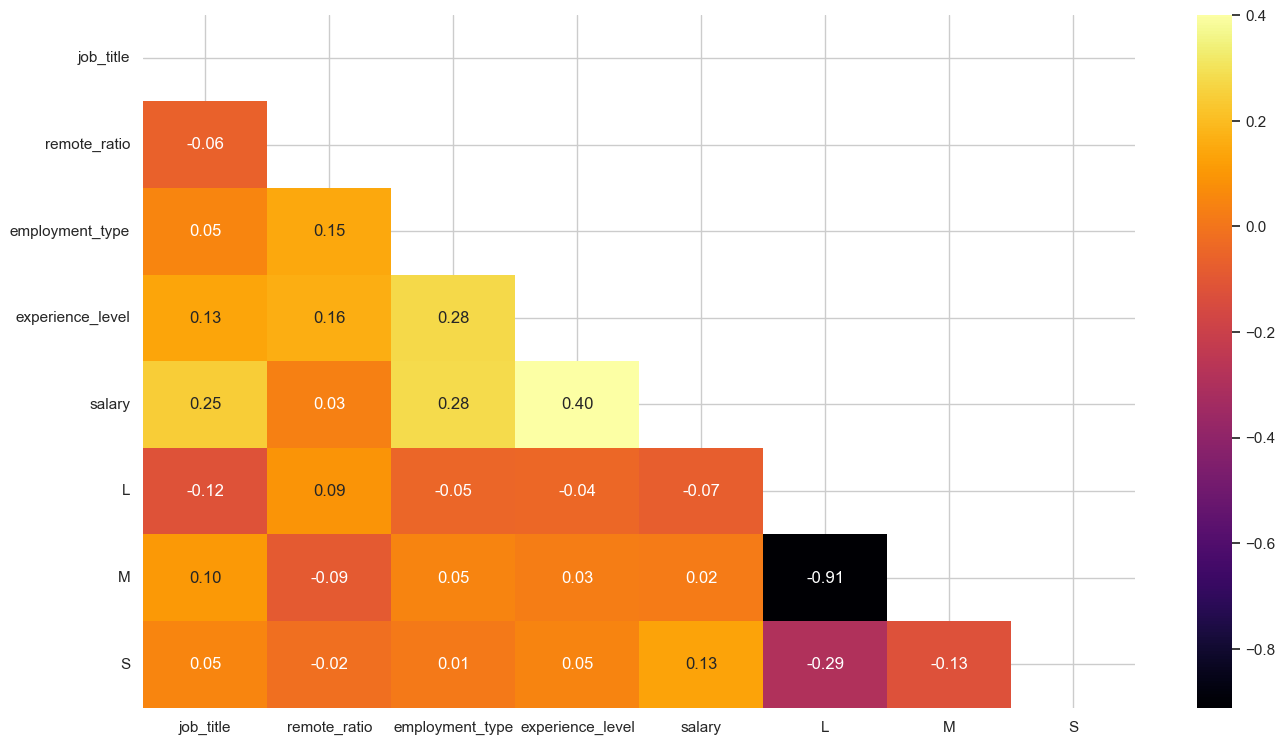

In [118]:
corr = prepared_linkedin.select_dtypes(exclude=['object']).drop(columns=['job_id']).corr()
sns.heatmap(corr, annot=True, cmap='inferno', fmt='.2f', mask=np.triu(corr));

#### Models

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [120]:
prepared_linkedin.dtypes

job_id                int64
job_title             int64
company_name         object
company_state        object
salary_range         object
remote_ratio          int64
employment_type       int64
experience_level      int64
company_size         object
image_link           object
employees            object
salary              float64
original_title       object
L                   float64
M                   float64
S                   float64
dtype: object

In [121]:
# X = prepared_linkedin.select_dtypes(exclude='object').drop(columns=['salary', 'min_salary', 'max_salary'])
X = prepared_linkedin.select_dtypes(exclude='object').drop(columns=['salary'])
y = prepared_linkedin['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [122]:
X_train.shape

(574, 8)

    LinearRegression

In [123]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [124]:
y_pred = regressor.predict(X_test)

In [125]:
metrics.r2_score(y_test, y_pred)

0.21024358876388693

    DecisionTreeRegressor

In [126]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [127]:
y_pred = regressor.predict(X_test)

In [128]:
metrics.r2_score(y_test, y_pred)

0.2311051650057513

    KNeighborsRegressor

In [129]:
regressor = KNeighborsRegressor()
regressor.fit(X_train, y_train)

KNeighborsRegressor()

In [130]:
y_pred = regressor.predict(X_test)

In [131]:
metrics.r2_score(y_test, y_pred)

0.39481542119781876

    GradientBoostingRegressor

In [132]:
regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

GradientBoostingRegressor()

In [133]:
y_pred = regressor.predict(X_test)

In [134]:
r2_grad = metrics.r2_score(y_test, y_pred)
r2_grad

0.5859585037926107

    Code to save the model

In [135]:
import pickle

# model_file = f'../models/GradientBoostingRegressor_r2_{r2_grad}.pkl'
# with open(model_file, 'wb') as f:
#     pickle.dump(regressor, f)

In [136]:
# model_file = '../models/GradientBoostingRegressor_r2_0.6336301605260248.pkl'
# with open(model_file, 'rb') as f:
#     model = pickle.load(f)

# pred = model.predict(X_test)
# # pred = model.predict(X_test.drop(columns=['min_salary', 'max_salary']))

# r2_pred = metrics.r2_score(y_test, pred)
# r2_pred

NameError: name 'pred' is not defined

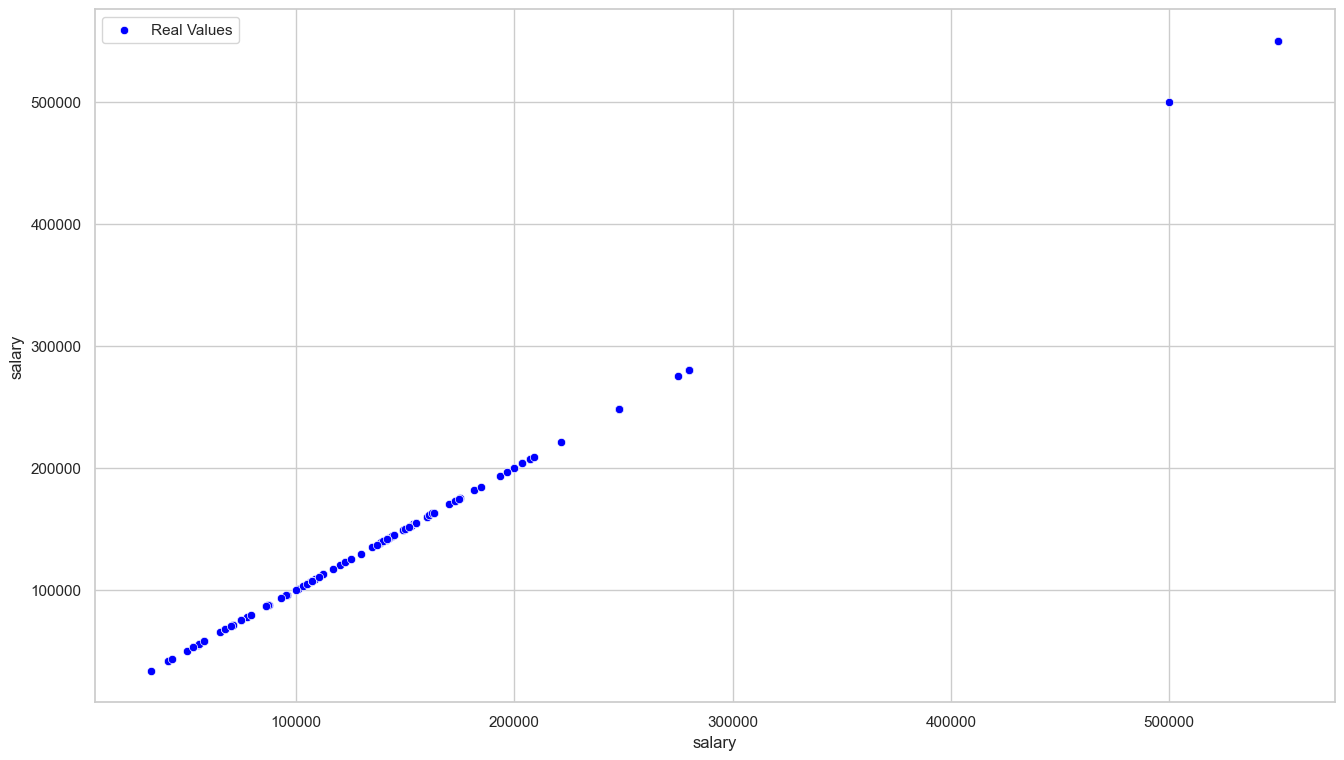

In [137]:
sns.scatterplot(x=y_test, y=y_test, color='blue', label='Real Values', marker='o')
sns.scatterplot(x=y_test, y=pred, color='red', label='Predictions', marker='x')

plt.xlabel('Real Salary Values')
plt.ylabel('Salary Predictions')
plt.title('Comparison between Salary Predictions and Real Values')
plt.legend()
# plt.savefig(f'../figures/RFRmodel_r2_{r2_pred}.jpg')
plt.show()

    RandomForestRegressor

In [ ]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
r2 = metrics.r2_score(y_test, y_pred)
r2

0.4859176673748766

    Code to save the model

In [ ]:
import pickle

# model_file = f'../models/RandomForestRegressor_r2_{r2}.pkl'
# with open(model_file, 'wb') as f:
#     pickle.dump(regressor, f)

In [ ]:
model_file = '../models/RandomForestRegressor_r2_0.6775482645582177.pkl'
with open(model_file, 'rb') as f:
    model = pickle.load(f)

pred = model.predict(X_test)
# pred = model.predict(X_test.drop(columns=['min_salary', 'max_salary']))

r2_pred = metrics.r2_score(y_test, pred)
r2_pred

0.8976069661019829

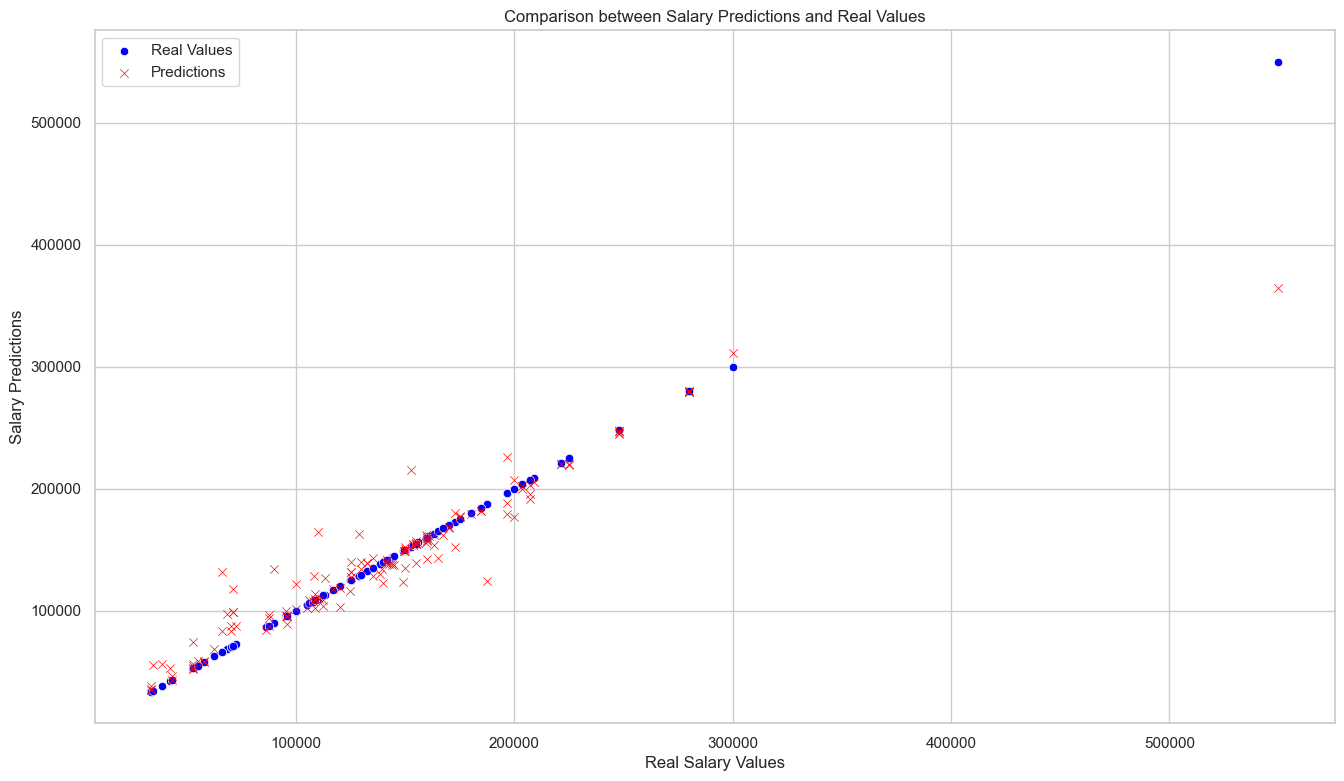

In [ ]:
sns.scatterplot(x=y_test, y=y_test, color='blue', label='Real Values', marker='o')
sns.scatterplot(x=y_test, y=pred, color='red', label='Predictions', marker='x')

plt.xlabel('Real Salary Values')
plt.ylabel('Salary Predictions')
plt.title('Comparison between Salary Predictions and Real Values')
plt.legend()
# plt.savefig(f'../figures/RFRmodel_r2_{r2_pred}.jpg')
plt.show()

#### TESTS with X_test

In [ ]:
X_test_copy = X_test.copy()
X_test_copy['pred_salary'] = y_pred
X_test_copy['salary'] = y_test
X_test_copy.sample(5)

,job_id,job_title,remote_ratio,employment_type,experience_level,L,M,S,pred_salary,salary
328,3764903612,5,50,4,0,1.0,0.0,0.0,53047.0,52800.0
395,3767322672,4,50,4,3,1.0,0.0,0.0,79764.6,62500.0
325,3764827498,4,50,4,0,1.0,0.0,0.0,53860.2,52800.0
505,3770505264,4,50,4,3,0.0,1.0,0.0,198527.8,135000.0
317,3764675617,6,0,2,3,1.0,0.0,0.0,137856.0,66240.0


#### Predictions

In [ ]:
prediction = model.predict(prepared_to_predict.select_dtypes(exclude=['object']).drop(columns=['salary']))

In [ ]:
to_predict['pred_salary'] = prediction

In [ ]:
linkedin = pd.concat([linkedin, to_predict])
linkedin.to_csv('../data/predicted.csv')